# Projet 2 - Préparez des données pour un organisme de santé publique

In [1]:
import os
import glob
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Only keep the following columns :
# 7: product_name
# 53: nutrition_grade_fr
# 63: energy_100g
# 65: fat_100g
# 66: saturated-fat_100g
# 101: carbohydrates_100g
# 102: sugars_100g
# 112: proteins_100g

cols_used = [7, 53, 63, 65, 66, 101, 102, 112]

chunk_size = 20000
batch_no = 1

dtype_cols = {
    7: str,  
    53: str,
    63: float,
    65: float,
    66: float,
    101: float,
    102: float,
    112: float,
}

# if there are files in the chunks folder, delete them
files = glob.glob('data/chunks/*')
for f in files:
    os.remove(f)

# split the csv file into chunks and save them in the chunks folder for later use
for chunk in pd.read_csv('data/fr.openfoodfacts.org.products.csv', sep='\t', chunksize=chunk_size, dtype=dtype_cols, usecols=cols_used):
    chunk.to_csv(f'data/chunks/fr.openfoodfacts.org.products_{batch_no:03d}.csv', index=False)
    batch_no += 1

In [2]:
# read the main csv file for processing
df = pd.read_csv('data/fr.openfoodfacts.org.products.csv', sep='\t', dtype=dtype_cols, usecols=cols_used)

# Faire des analyses de distribution sur les colonnes

Pour comprendre le jeu de données, je procède ici à l'affichage indépendant de chacun des colonnes sous la forme d'un diagramme à moustache.

Faisons une première analyse des données avec describe

In [3]:
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
count,2.611130e+05,243891.000000,229554.000000,243588.000000,244971.000000,259922.000000
mean,1.141915e+03,12.730379,5.129932,32.073981,16.003484,7.075940
std,6.447154e+03,17.578747,8.014238,29.731719,22.327284,8.409054
min,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-800.000000
25%,3.770000e+02,0.000000,0.000000,6.000000,1.300000,0.700000
50%,1.100000e+03,5.000000,1.790000,20.600000,5.710000,4.760000
75%,1.674000e+03,20.000000,7.140000,58.330000,24.000000,10.000000
max,3.251373e+06,714.290000,550.000000,2916.670000,3520.000000,430.000000


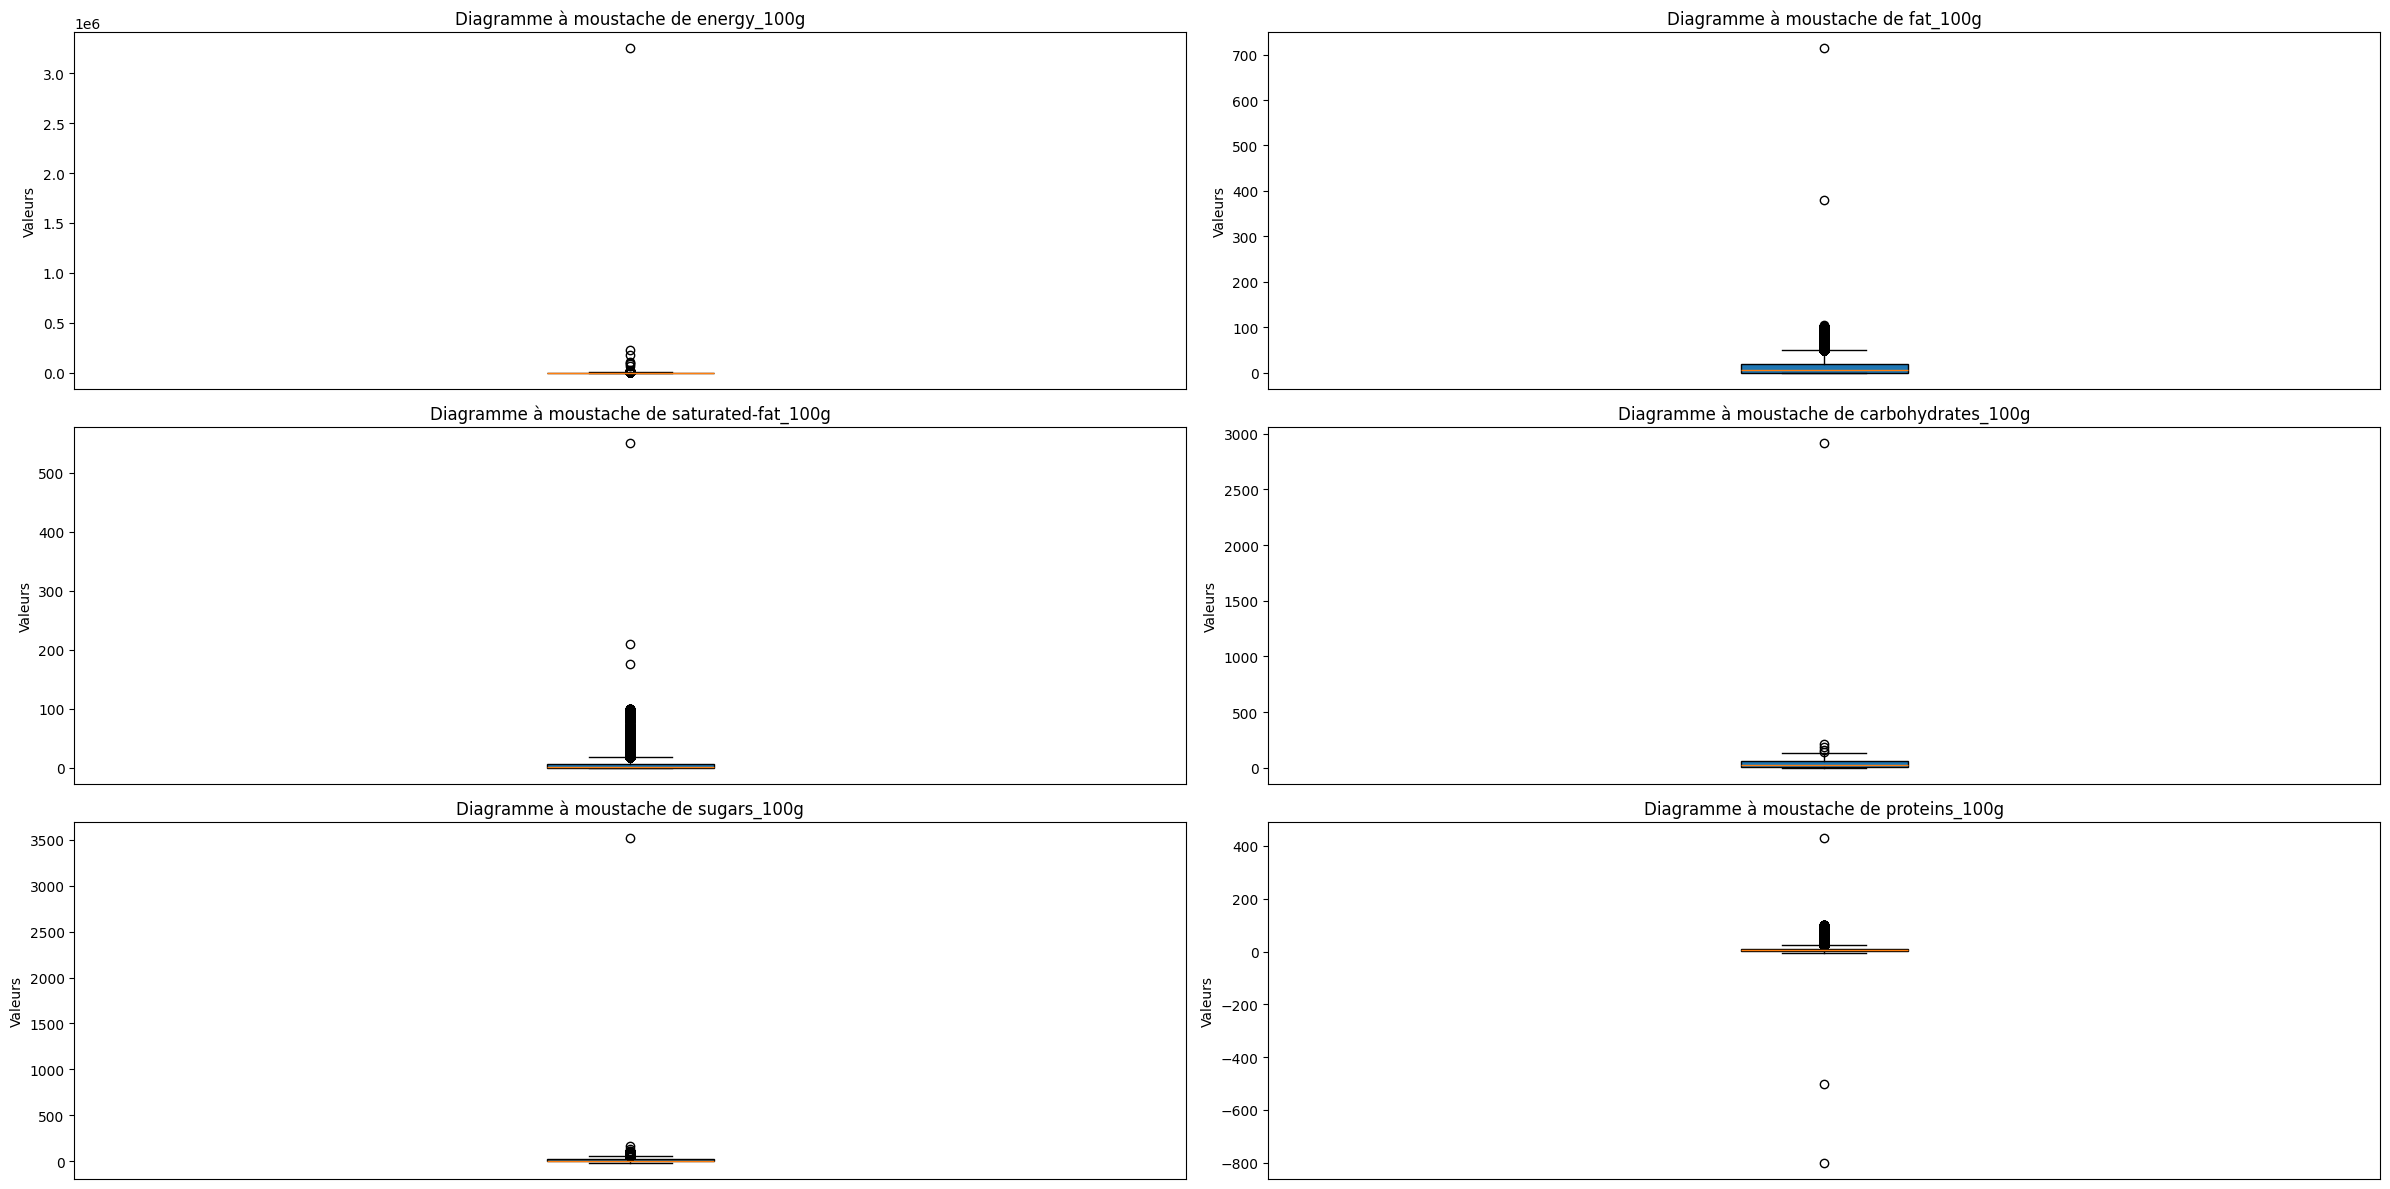

In [4]:
import matplotlib.pyplot as plt
import math

# Données pour le graphique
columns_to_plot = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
data_to_plot = [df[col].dropna() for col in columns_to_plot]

# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(len(columns_to_plot) / 2)

# Ajuster la taille de la figure
fig, axs = plt.subplots(num_rows, 2, figsize=(12*2, 4*num_rows))
axs = axs.ravel()

for idx, col in enumerate(columns_to_plot):
    axs[idx].boxplot(data_to_plot[idx], vert=True, patch_artist=True)
    axs[idx].set_title(f'Diagramme à moustache de {col}')
    axs[idx].set_ylabel('Valeurs')
    axs[idx].set_xticks([])

# Supprimer les axes non utilisés s'il y en a
for idx in range(len(columns_to_plot), num_rows*2):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


On constate que la plupart des colonnes contiennent des données aberrantes (à part nutrition-score-fr_100g). Enlevons les pour améliorer les résultats de nos analyses par la suite.

In [5]:
cols_to_filter = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']

Q1 = df[cols_to_filter].quantile(0.25)
Q3 = df[cols_to_filter].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in cols_to_filter:
    df = df[(df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col])]



On réaffiche les diagrammes à moustache.

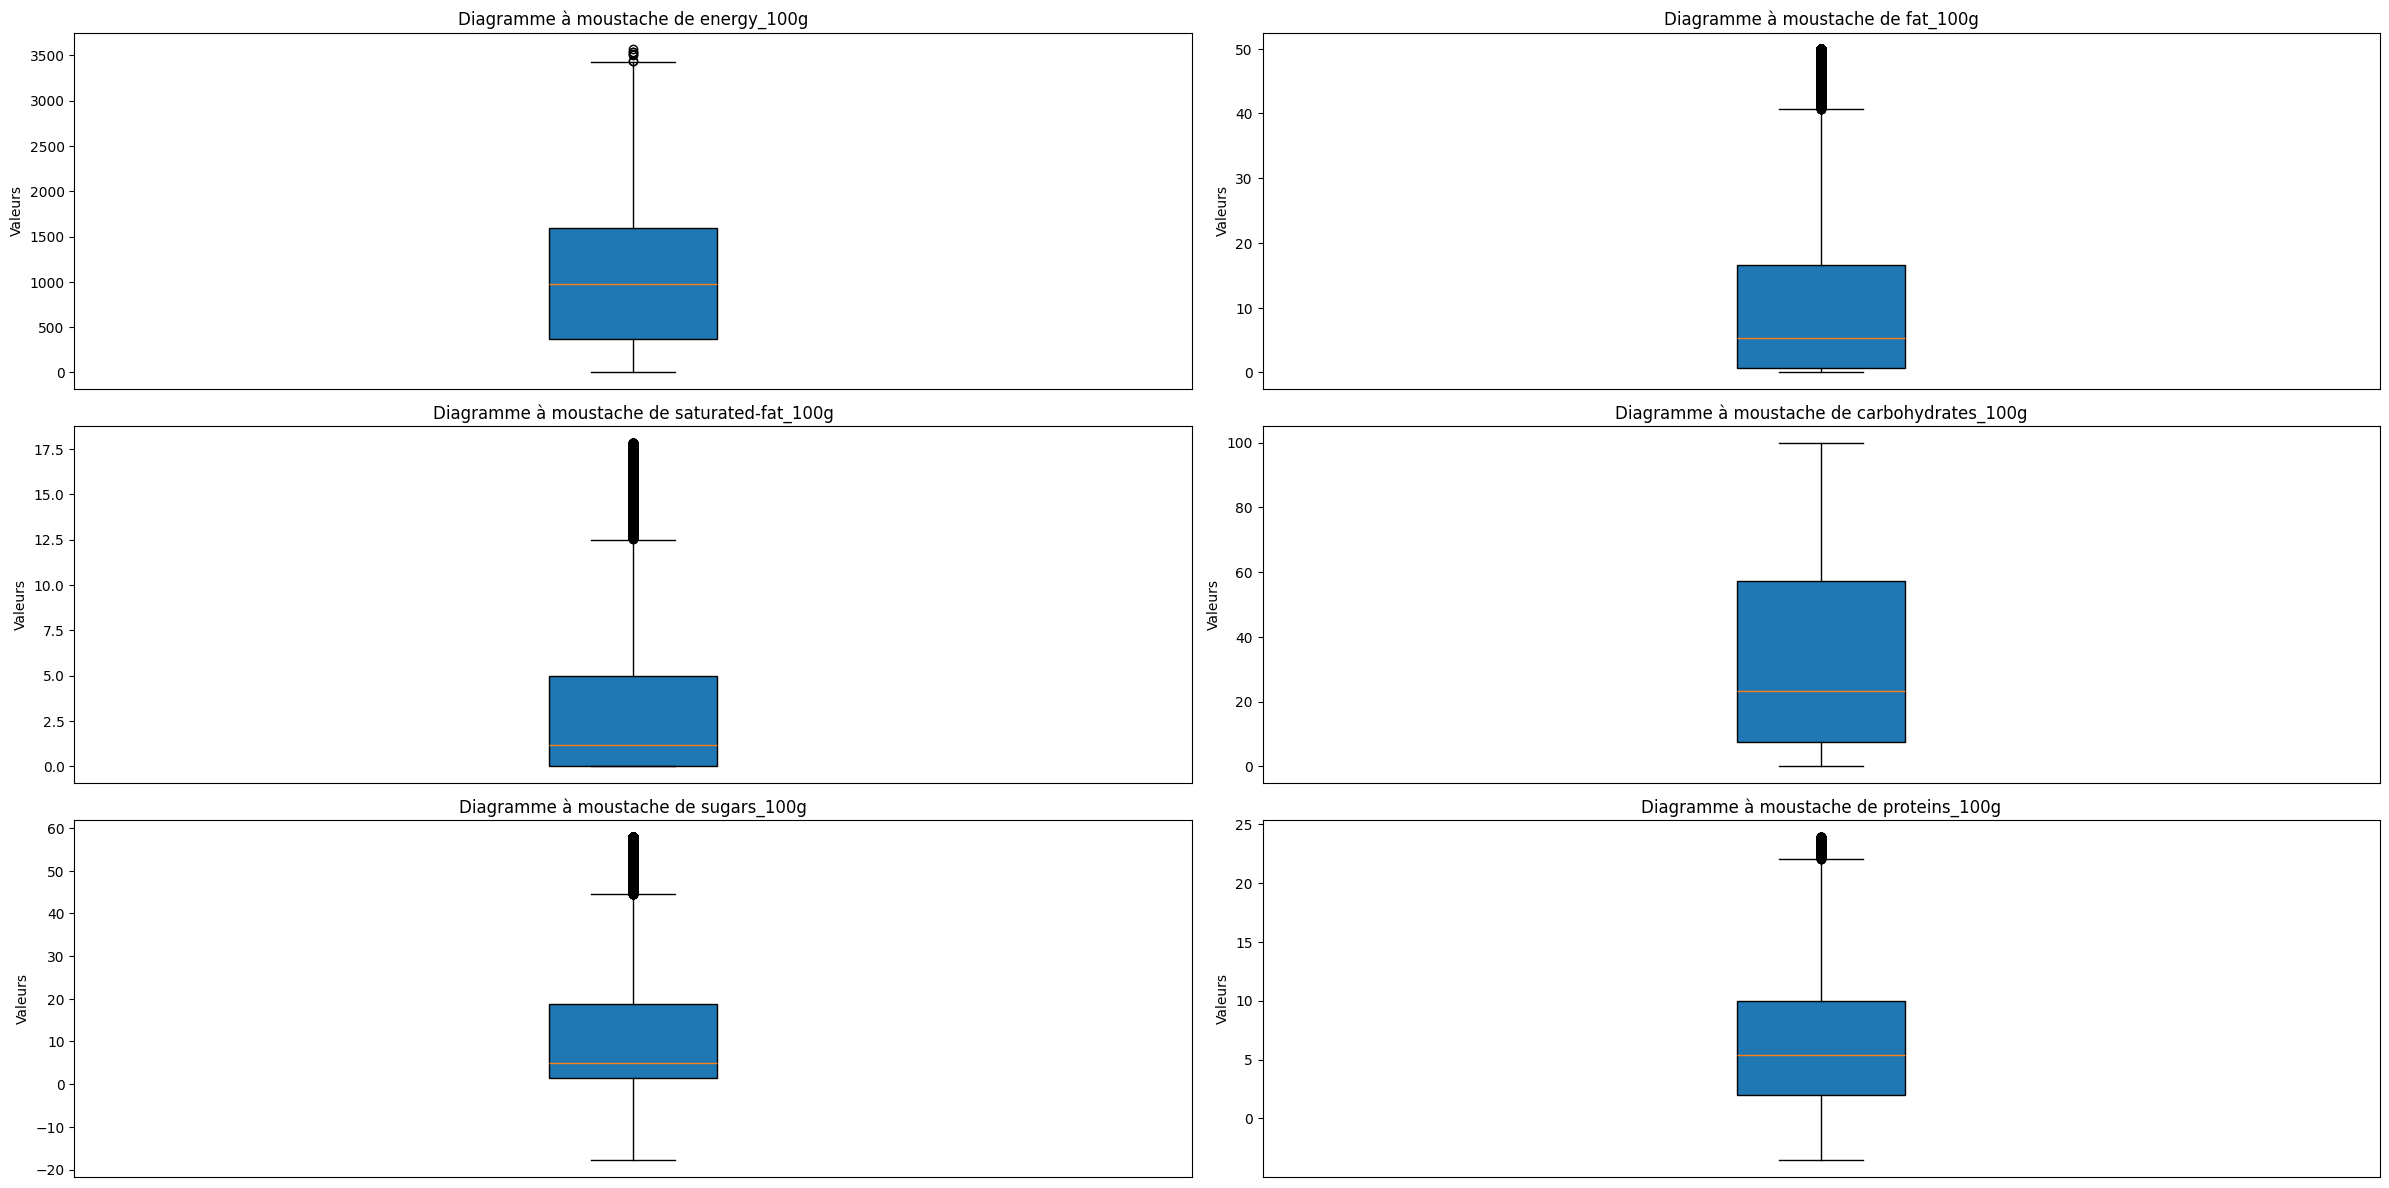

In [6]:
import matplotlib.pyplot as plt
import math

# Données pour le graphique
columns_to_plot = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
data_to_plot = [df[col].dropna() for col in columns_to_plot]

# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(len(columns_to_plot) / 2)

# Ajuster la taille de la figure
fig, axs = plt.subplots(num_rows, 2, figsize=(12*2, 4*num_rows))
axs = axs.ravel()

for idx, col in enumerate(columns_to_plot):
    axs[idx].boxplot(data_to_plot[idx], vert=True, patch_artist=True)
    axs[idx].set_title(f'Diagramme à moustache de {col}')
    axs[idx].set_ylabel('Valeurs')
    axs[idx].set_xticks([])

# Supprimer les axes non utilisés s'il y en a
for idx in range(len(columns_to_plot), num_rows*2):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


## Méthode 1 de traitement des valeurs manquantes : Suppression des N/A
Cette méthode consiste à enlever les observations qui contiennent des valeurs nulles ou manquantes pour la colonne donnée.
Ici la colonne ciblée est "nutrition_grade_fr", qui est la principale colonne de notre jeu de données, et pour laquelle des valeurs manquantes est trop gênant.

In [7]:
# Enlever les valeurs nulles ou manquantes pour la colonne nutrition_grade_fr
df = df.dropna(subset=['nutrition_grade_fr'])

# # Enlever les valeurs nulles ou manquantes pour la colonne carbohydrates_100g
# df = df.dropna(subset=['carbohydrates_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne sugars_100g
# df = df.dropna(subset=['sugars_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne proteins_100g
# df = df.dropna(subset=['proteins_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne nutrition-score-fr_100g
# df = df.dropna(subset=['nutrition-score-fr_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne energy_100g
# df = df.dropna(subset=['energy_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne fat_100g
# df = df.dropna(subset=['fat_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne saturated-fat_100g
# df = df.dropna(subset=['saturated-fat_100g'])

## Méthode 2 de traitement des valeurs manquantes : Utilisation de la valeur médiane
Cette méthode consiste à remplacer la valeur de la colonne ciblée des observations qui contiennent des valeurs nulles ou manquantes pour cette colonne par la valeur médiane de cette colonne. Ici la médiane est utilisée car elle est moins sensible aux valeurs abérrantes (outliers)

Ici la colonne ciblée est "sugars_100g".

In [8]:
df['sugars_100g'].fillna(df['sugars_100g'].median(), inplace=True)

## Méthode 3 de traitement des valeurs manquantes : Utilisation de la bibliothèque sklearn.impute pour une imputation k des plus proches voisins (KNN)
Cette méthode consiste à utiliser l'algorithme des k-plus proches voisins (KNN) pour estimer et remplacer les valeurs manquantes. KNN prend en compte les k observations les plus proches d'une observation avec une valeur manquante pour imputer une valeur. La proximité est souvent mesurée à l'aide d'une métrique de distance, telle que la distance euclidienne.

Dans cette approche, plutôt que de remplacer la valeur manquante par une valeur unique (comme la moyenne ou la médiane), l'algorithme utilise plusieurs observations les plus proches pour estimer une valeur manquante.

Ici la colonne ciblée est "fat_100g".

In [9]:
import numpy as np
from sklearn.impute import KNNImputer

# On ne prend en compte que les valeurs manquantes
mask = df['fat_100g'].isna()

# On applique le KNNImputer à ces valeurs manquantes
imputer = KNNImputer(n_neighbors=5)
df.loc[mask, 'fat_100g'] = imputer.fit_transform(df[['fat_100g']])[mask]


### Utilisation de la méthode d'imputation KNN à la colonne carbohydrates_100g

In [10]:
# On ne prend en compte que les valeurs manquantes
mask = df['carbohydrates_100g'].isna()

# On applique le KNNImputer à ces valeurs manquantes
imputer = KNNImputer(n_neighbors=5)
df.loc[mask, 'carbohydrates_100g'] = imputer.fit_transform(df[['carbohydrates_100g']])[mask]

In [11]:
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
count,168267.000000,168267.000000,168267.000000,168267.000000,168267.000000,168267.000000
mean,1028.840109,10.136463,3.256536,32.251177,12.057404,6.664594
std,696.680291,11.578038,4.355734,26.936906,14.722706,5.843499
min,0.000000,0.000000,0.000000,0.000000,-17.860000,-3.570000
25%,368.000000,0.700000,0.000000,7.550000,1.540000,2.000000
50%,975.000000,5.360000,1.200000,23.300000,4.900000,5.380000
75%,1598.000000,16.800000,5.070000,57.140000,18.775000,10.000000
max,3573.000000,50.000000,17.840000,100.000000,58.000000,23.940000


### On enlève les quelques données manquantes des colonnes proteins_100g et saturated-fat_100g

In [12]:
# Enlever les valeurs nulles ou manquantes pour la colonne proteins_100g
df = df.dropna(subset=['proteins_100g'])

# Enlever les valeurs nulles ou manquantes pour la colonne saturated-fat_100g
df = df.dropna(subset=['saturated-fat_100g'])

In [13]:
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
count,168267.000000,168267.000000,168267.000000,168267.000000,168267.000000,168267.000000
mean,1028.840109,10.136463,3.256536,32.251177,12.057404,6.664594
std,696.680291,11.578038,4.355734,26.936906,14.722706,5.843499
min,0.000000,0.000000,0.000000,0.000000,-17.860000,-3.570000
25%,368.000000,0.700000,0.000000,7.550000,1.540000,2.000000
50%,975.000000,5.360000,1.200000,23.300000,4.900000,5.380000
75%,1598.000000,16.800000,5.070000,57.140000,18.775000,10.000000
max,3573.000000,50.000000,17.840000,100.000000,58.000000,23.940000


On réaffiche les diagrammes à moustaches pour vérifier que nos modifications n'ont pas introduit de données aberrantes.

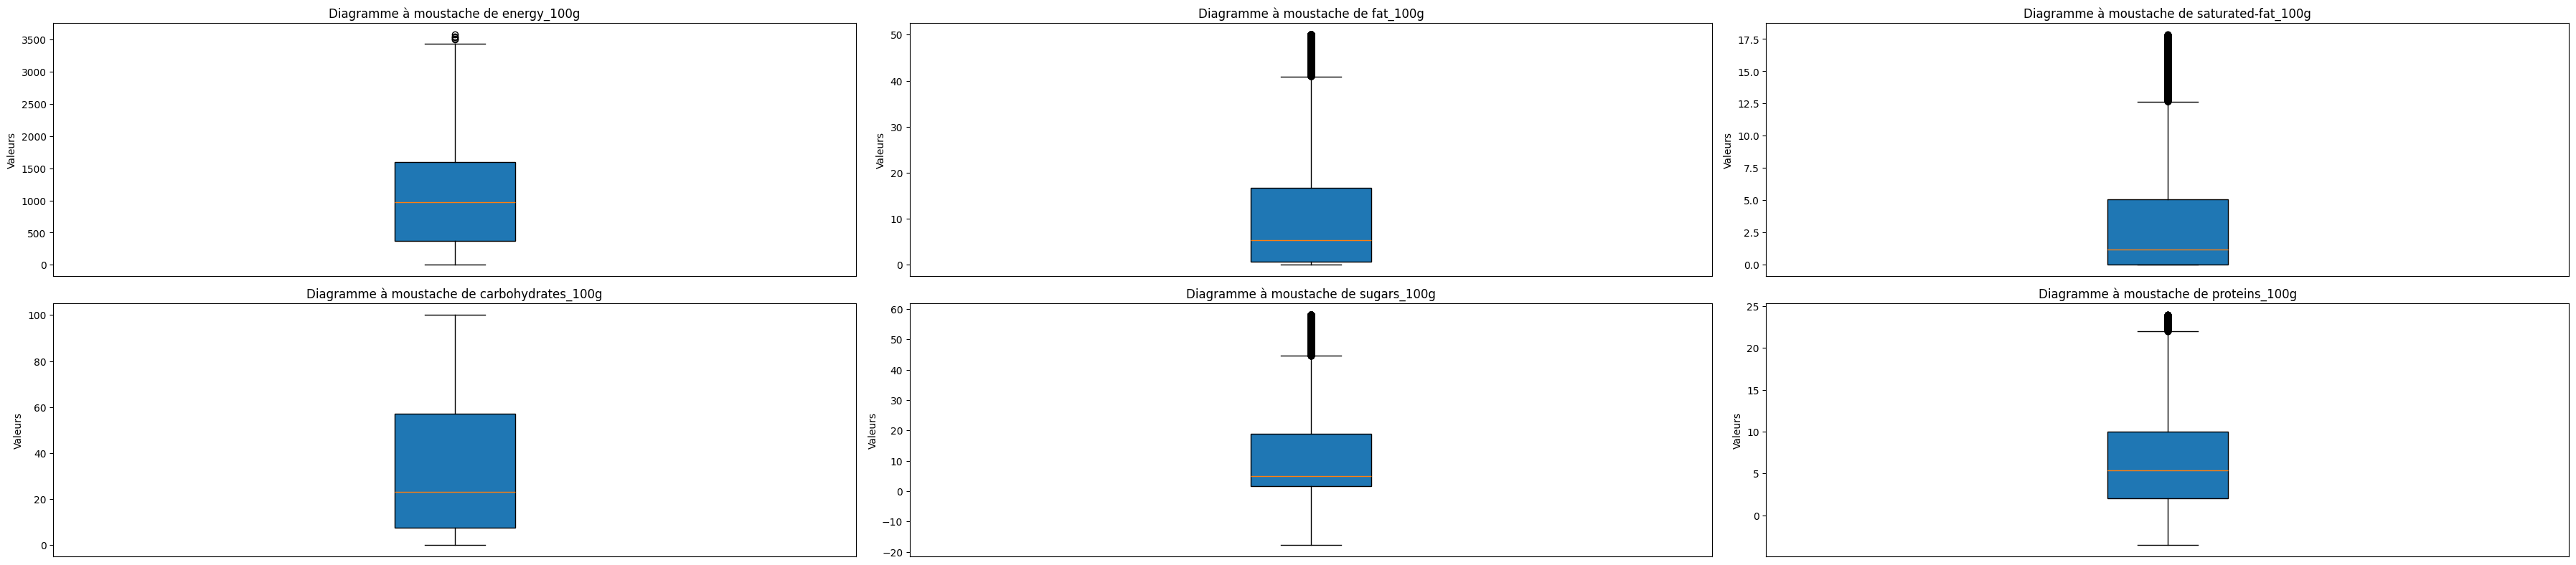

In [14]:
import matplotlib.pyplot as plt
import math

# Données pour le graphique
columns_to_plot = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
data_to_plot = [df[col].dropna() for col in columns_to_plot]

# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(len(columns_to_plot) / 3)

# Ajuster la taille de la figure
fig, axs = plt.subplots(num_rows, 3, figsize=(12*3, 4*num_rows))
axs = axs.ravel()

for idx, col in enumerate(columns_to_plot):
    axs[idx].boxplot(data_to_plot[idx], vert=True, patch_artist=True)
    axs[idx].set_title(f'Diagramme à moustache de {col}')
    axs[idx].set_ylabel('Valeurs')
    axs[idx].set_xticks([])

# Supprimer les axes non utilisés s'il y en a
for idx in range(len(columns_to_plot), num_rows*3):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

### On constate que maintenant toutes les colonnes sont remplies et utilisables pour les analyses.

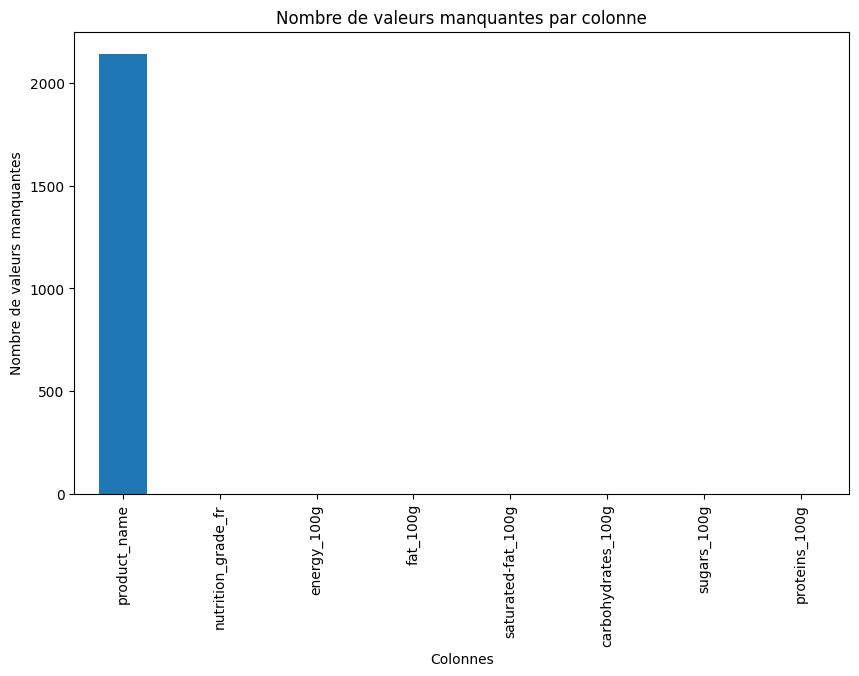

In [15]:
import matplotlib.pyplot as plt

# Compter les valeurs manquantes pour chaque colonne
missing_values = df.isna().sum()

# Afficher graphiquement
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title('Nombre de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs manquantes')
plt.show()

### La colonne 'product_name' ne participera pas aux analyses donc nous pouvons y admettre des valeurs manquantes.

In [16]:
df.sample(20)

,product_name,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
190126,Sauce Bolognaise,c,318.0,3.10,1.20,6.30,4.60,5.10
73504,Gingerbread House Kit,d,1674.0,8.33,1.67,80.00,50.00,3.33
264176,NaN,e,192.0,0.00,0.00,11.20,11.20,0.00
193596,Rôti de porc cuit Bio,c,545.0,3.80,1.40,0.80,0.80,23.00
207518,Biscuits nappés chocolat,e,2066.0,23.20,13.30,65.80,15.70,3.30
103598,Thick & Chunky Pineapple Peach Salsa,b,209.0,0.00,0.00,13.33,10.00,0.00
11925,Rice Pilaf,c,1435.0,1.43,0.00,74.29,1.43,10.00
192798,Tortis et Concombres au Saumon,b,714.0,10.00,1.00,13.50,1.50,6.00
106511,Greek Yogurt Dip Mix,d,1163.0,0.00,0.00,55.56,0.00,0.00
166340,"Double Blue, Wild Caught Sockeye Salmon Portions",a,297.0,1.33,0.00,0.00,0.00,14.16


In [17]:
df.shape

(168267, 8)

Après nettoyage des données aberrantes, et remplissage des données manquantes selon 3 méthodes différentes, nous obtenons un ensemble de 168267 observations et 9 variables. Nous pouvons maintenant commencer les analyses.

# Analyse univariée des colonnes

### nutrition_grade_fr

In [18]:

df['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
d    43889
c    38265
a    32279
b    30603
e    23231
Name: count, dtype: int64

<Axes: xlabel='nutrition_grade_fr'>

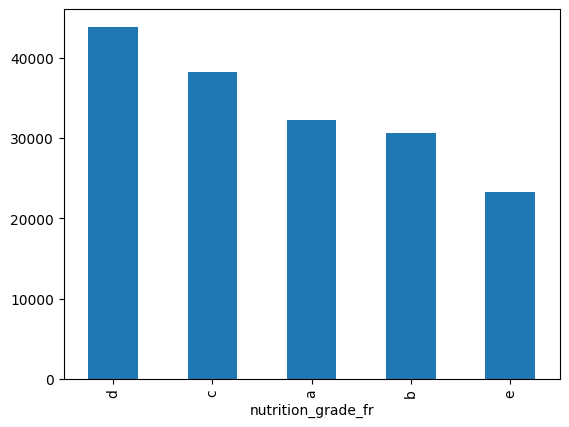

In [19]:
df['nutrition_grade_fr'].value_counts().plot.bar()

# Analyse multivariée : nuage de points

In [20]:
# Transform nutrition_grade_fr column to numeric
df['nutrition_grade_fr'] = df['nutrition_grade_fr'].map({'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5})

# drop the product_name column because it's useless for the model
df_without_name = df.drop(columns=['product_name'])





In [21]:
# correlation matrix
corr = df_without_name.corr()
corr

,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
nutrition_grade_fr,1.000000,0.540204,0.578086,0.660329,0.267147,0.509473,0.038972
energy_100g,0.540204,1.000000,0.748878,0.555601,0.735848,0.418425,0.378661
fat_100g,0.578086,0.748878,1.000000,0.719442,0.151879,0.175745,0.330492
saturated-fat_100g,0.660329,0.555601,0.719442,1.000000,0.132424,0.321503,0.211522
carbohydrates_100g,0.267147,0.735848,0.151879,0.132424,1.000000,0.529085,0.071628
sugars_100g,0.509473,0.418425,0.175745,0.321503,0.529085,1.000000,-0.203526
proteins_100g,0.038972,0.378661,0.330492,0.211522,0.071628,-0.203526,1.000000


<Axes: >

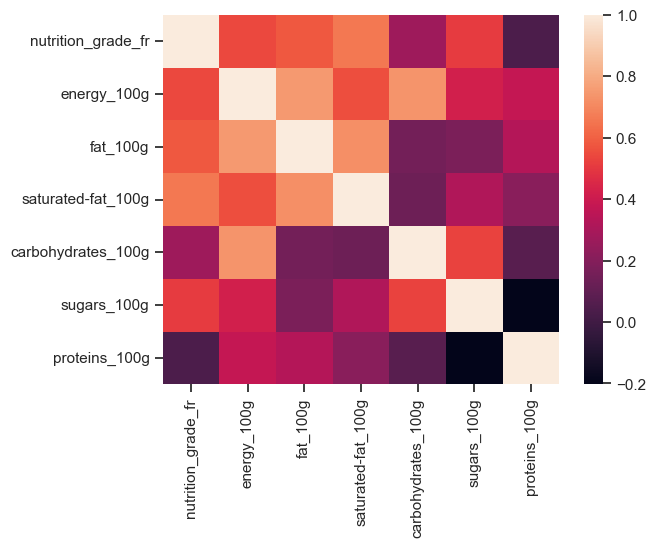

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks", color_codes=True)

cmap = sns.diverging_palette(220, 10, as_cmap=True)


# heatmap
plt.figure()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)




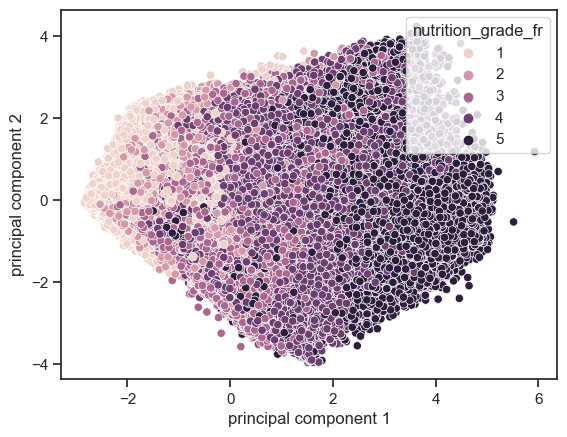

In [23]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Normalisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_without_name)

# Application de PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Création d'un DataFrame pour le résultat de PCA
pca_df = pd.DataFrame(data = pca_result, columns = ['principal component 1', 'principal component 2'])

# Ajout de la colonne 'nutrition_grade_fr' au DataFrame PCA
pca_df['nutrition_grade_fr'] = df_without_name['nutrition_grade_fr'].reset_index(drop=True)

# Visualisation
plt.figure()
sns.scatterplot(x='principal component 1', y='principal component 2', hue='nutrition_grade_fr', data=pca_df)
plt.show()


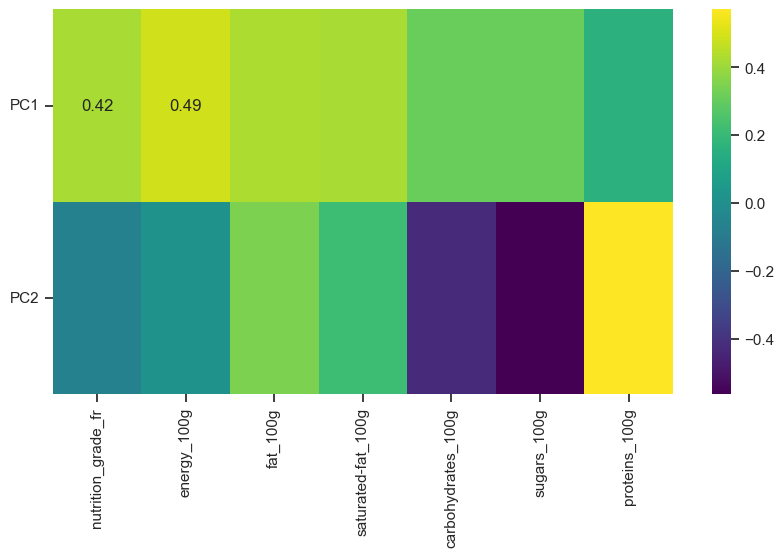

In [24]:
components = pca.components_

components_df = pd.DataFrame(components, columns=df_without_name.columns, index=['PC1', 'PC2'])

import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(components_df, annot=True, cmap='viridis', cbar=True)
plt.yticks(rotation=0)
plt.show()


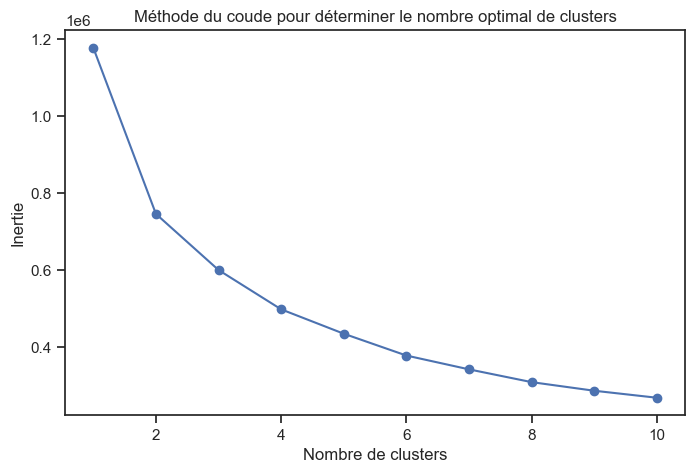

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Liste pour stocker les inerties pour chaque nombre de clusters
inertias = []

# Définition de la plage de clusters à tester (par exemple, de 1 à 10)
range_clusters = range(1,11)

# Boucle pour ajuster KMeans pour chaque nombre de clusters
for num_clusters in range_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(scaled_data)  # Remplacez par vos données
    inertias.append(kmeans.inertia_)

# Tracer le graphique
plt.figure(figsize=(8,5))
plt.plot(range_clusters, inertias, '-o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()


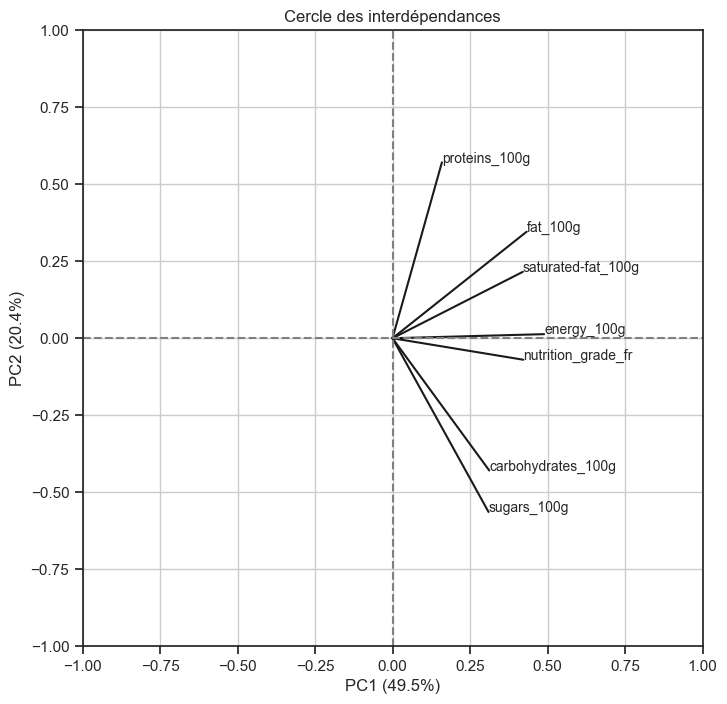

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_without_name)

# 2. ACP
pca = PCA()
pca_result = pca.fit(scaled_data)

# 3. Visualisation
plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (label) de la variable
    plt.text(x, y, df_without_name.columns[i], fontsize='smaller')
    
# Définir les limites du graphique et les titres des axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axvline(0, color='grey', linestyle='--')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des interdépendances")
plt.grid(True)

plt.show()


continuer sur analyse bivariee
Marin Bouthemy
11:32
(PCA: regarder le cours) pour voir la methode du coude, le cercle des visualisations, les compoentns principales


On pourra voir ensemble la semaine pro les tests stats